In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
from skimage.io import imread

# Root folder containing AP and LA
root_dir = '/Users/krishshah/Desktop/Krish_Sky_Long_AI/resized_dataset'

data = []
pattern = r'(\d+)-([MF])-0*(\d+)Y\d*\.jpg'

for angle in ['AP', 'LA']:
    folder = os.path.join(root_dir, angle)
    count = 0
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            match = re.match(pattern, fname)
            if not match:
                print(f"Filename skipped (pattern mismatch): {fname}")
                continue
            # _, sex, age = match.groups()  # Sex not needed now
            age = int(match.group(3))
            image_path = os.path.join(folder, fname)
            try:
                image = imread(image_path)
            except Exception as e:
                print(f"Could not read image {image_path}: {e}")
                continue
            data.append({
                'filename' : fname,
                'image': image,
                'age': age
            })
            count += 1
            if count >= 200:  # Stop after 200 images
                break

# Build DataFrame with just image and age columns
df_images = pd.DataFrame(data, columns=['filename', 'image', 'age'])
print(df_images.shape)
print(df_images.head())


(400, 3)
           filename                                              image  age
0  6644-F-070Y0.jpg  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...   70
1  0810-M-069Y0.jpg  [[[253, 253, 253], [255, 255, 255], [245, 245,...   69
2  2237-F-052Y0.jpg  [[[2, 2, 2], [2, 2, 2], [1, 1, 1], [1, 1, 1], ...   52
3  2340-M-011Y0.jpg  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   11
4  5665-F-056Y0.jpg  [[[186, 186, 186], [177, 177, 177], [171, 171,...   56


In [3]:
df_features = pd.read_csv('/Users/krishshah/Desktop/Krish_Sky_Long_AI/spine_final_features.csv') 
df_features.drop(columns='age', inplace=True)
print(df_features.head())

           filename sex image_angle  texture_score  angular_second_moment  \
0  6644-F-070Y0.jpg   F          AP       5.848347               0.002732   
1  0810-M-069Y0.jpg   M          AP       5.572797               0.002303   
2  2237-F-052Y0.jpg   F          AP       5.034474               0.002160   
3  2340-M-011Y0.jpg   M          AP       4.765994               0.010484   
4  5665-F-056Y0.jpg   F          AP       6.121614               0.001557   

   contrast  correlation     variance  homogenity     sum_avg  ...    entropy  \
0  4.242053     0.999216  2705.805860    0.539442  194.648605  ...  10.083143   
1  3.442829     0.999130  1978.365873    0.635196  157.049372  ...   9.595937   
2  2.759799     0.999147  1617.685619    0.608874  159.304077  ...   9.704208   
3  3.792553     0.999298  2701.075858    0.628478  146.126823  ...   9.398084   
4  2.959909     0.999112  1666.954338    0.598383  214.666826  ...   9.864309   

   diff_var  diff_entropy  im_corr_1  im_corr_2  e

In [4]:
df = pd.merge(df_images, df_features, on='filename', how='inner')
df = df.sample(frac=1, random_state=41).reset_index(drop=True) # shuffles the dataframe
df.dropna()

,filename,image,age,sex,image_angle,texture_score,angular_second_moment,contrast,correlation,variance,...,entropy,diff_var,diff_entropy,im_corr_1,im_corr_2,edge_score,edge_density,edge_entropy,shape_score,moments_score
0,5820-M-038Y1.jpg,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [2, 2, 2], ...",38,M,LA,5.912105,0.073693,1.222436,0.999842,3875.306956,...,7.769212,0.002056,1.365140,-0.776918,0.999972,0.274551,0.004973,0.045210,4.414775,58.954934
1,4409-M-024Y1.jpg,"[[[129, 129, 129], [136, 136, 136], [137, 137,...",24,M,LA,5.702299,0.013073,2.658421,0.999477,2541.695034,...,8.155514,0.001514,1.888063,-0.642393,0.999758,0.582036,0.232192,0.781814,2.212279,60.379322
2,6240-F-027Y0.jpg,"[[[15, 15, 15], [15, 15, 15], [17, 17, 17], [1...",27,F,AP,6.082751,0.005301,1.776519,0.999730,3295.790365,...,9.426721,0.001859,1.727368,-0.713332,0.999984,0.428057,0.032874,0.208604,4.127125,59.350379
3,1015-F-044Y1.jpg,"[[[94, 94, 94], [95, 95, 95], [97, 97, 97], [9...",44,F,LA,4.776840,0.012829,1.284731,0.999763,2711.543515,...,8.790735,0.001928,1.425371,-0.761979,0.999989,0.293765,0.008372,0.069793,4.144477,59.099595
4,5820-M-038Y0.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",38,M,AP,4.726273,0.001514,2.841820,0.999338,2148.655663,...,9.915765,0.001408,1.885108,-0.676658,0.999978,0.488345,0.051707,0.293602,3.987318,59.303712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,6478-M-069Y0.jpg,"[[[113, 113, 113], [113, 113, 113], [113, 113,...",69,M,AP,6.057476,0.011206,4.762420,0.998787,1963.817946,...,9.554812,0.001465,2.242471,-0.609625,0.999868,0.786374,0.095708,0.455241,2.604058,59.811402
396,1428-M-065Y1.jpg,"[[[5, 5, 5], [12, 12, 12], [0, 0, 0], [16, 16,...",65,M,LA,6.381316,0.041909,2.343829,0.999767,5030.351615,...,8.607223,0.001756,1.752157,-0.721180,0.999967,0.460707,0.055840,0.310704,3.733612,60.133972
397,8251-F-074Y1.jpg,"[[[3, 3, 3], [3, 3, 3], [3, 3, 3], [2, 2, 2], ...",74,F,LA,5.841075,0.004562,2.366100,0.999662,3501.002697,...,9.770997,0.001502,1.856346,-0.695683,0.999984,0.503431,0.041599,0.249577,4.146408,59.581048
398,2911-F-056Y0.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",56,F,AP,4.603261,0.022803,4.064577,0.999406,3418.938480,...,9.037444,0.001495,1.956633,-0.678633,0.999949,0.459544,0.058567,0.321730,4.389993,59.175235


In [5]:
from sklearn.preprocessing import OneHotEncoder

drop_binary_enc = OneHotEncoder(drop='if_binary', sparse_output=False)
X_encoded = drop_binary_enc.fit_transform(df[['sex', 'image_angle']])
X_encoded_df = pd.DataFrame(X_encoded, columns=drop_binary_enc.get_feature_names_out(['sex', 'image_angle']))
X_final = pd.concat([X_encoded_df, df.drop(columns=['sex', 'image_angle'])], axis=1)
X_final = X_final.dropna()
df = X_final
df.to_csv('/Users/krishshah/Desktop/Krish_Sky_Long_AI/dual_train_data.csv')

In [6]:
features_list = [col for col in df.columns if col not in ['filename', 'image', 'age']]
print(features_list)

['sex_M', 'image_angle_LA', 'texture_score', 'angular_second_moment', 'contrast', 'correlation', 'variance', 'homogenity', 'sum_avg', 'sum_var', 'sum_entropy', 'entropy', 'diff_var', 'diff_entropy', 'im_corr_1', 'im_corr_2', 'edge_score', 'edge_density', 'edge_entropy', 'shape_score', 'moments_score']


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from skimage.color import rgb2gray
from PIL import Image

class DualInputDataset2(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.loc[idx, 'image']      # numpy array
        features = self.df.loc[idx, features_list].values.astype(np.float32)  # e.g. 1D np array of features
        age = self.df.loc[idx, 'age']

        if img.ndim == 3 and img.shape[-1] == 3:
            img = rgb2gray(img)
            img = np.expand_dims(img, axis=0)
        elif img.ndim == 2:
            img = np.expand_dims(img, axis=0)

        if self.transform:
            img = self.transform(img)
        else:
            # If no transform, do the torch conversion manually
            img = torch.tensor(img, dtype=torch.float32)
            if img.max() > 1.0:
                img = img / 255.0

        features = torch.tensor(features, dtype=torch.float32)
        age = torch.tensor(age, dtype=torch.float32)

        return img, features, age

class DualInputDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.loc[idx, 'image']
        features = self.df.loc[idx, features_list].values.astype(np.float32)  # e.g. 1D np array of features
        age = self.df.loc[idx, 'age']

        # Convert numpy array to PIL image
        if img.ndim == 3 and img.shape[-1] == 3:
            img = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            img = img.convert("L")
        elif img.ndim == 2:
            img = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            img = img.convert("L")

        if self.transform:
            img = self.transform(img)  # Transforms: Resize, ToTensor, Normalize, etc.

        features = torch.tensor(features, dtype=torch.float32)
        age = torch.tensor(age, dtype=torch.float32)
        return img, features, age



In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=41)
train_df, val_df  = train_test_split(train_df, test_size=1/9, random_state=41)

In [9]:
# 2 different augmentations per training dataset

import albumentations as A

augment1 = A.Compose([
    A.Rotate(limit=12, p=1.0),
    A.GaussianBlur(blur_limit=(17, 31), p=1.0)
])

augment2 = A.Compose([
    A.Affine(translate_percent={"x": 0.08, "y": 0.08}, scale=(0.95, 1.05), rotate=0, p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.22, contrast_limit=0.22, p=1.0)
])

In [10]:
# creates and adds augmented types to the training set. 

def augment(df):
    augmented_rows = []

    for idx, row in df.iterrows():
        image = row['image']

        # Original row (label as 0.0)
        orig_row = row.copy()
        orig_row['augmentation_type'] = 0.0
        augmented_rows.append(orig_row)

        # Augmentation 1
        aug_img1 = augment1(image=image)['image']
        row_aug1 = row.copy()
        row_aug1['image'] = aug_img1
        row_aug1['augmentation_type'] = 1.0
        augmented_rows.append(row_aug1)

        # Augmentation 2
        aug_img2 = augment2(image=image)['image']
        row_aug2 = row.copy()
        row_aug2['image'] = aug_img2
        row_aug2['augmentation_type'] = 2.0
        augmented_rows.append(row_aug2)

    # Create new DataFrame from all rows
    df_augmented = pd.DataFrame(augmented_rows).reset_index(drop=True)

    return df_augmented

In [ ]:
train_df = augment(train_df)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EfficientNetTabularAgeRegressor(nn.Module):
    def __init__(self, in_channels=1, n_tabular_features=len(features_list), tabular_hidden=32, dropout=0.3):
        super().__init__()
        # EfficientNet backbone (image)
        self.backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")
        if in_channels == 1:
            self.backbone.features[0][0] = nn.Conv2d(
                1, 32, kernel_size=3, stride=2, padding=1, bias=False
            )
        self.backbone.classifier = nn.Identity()
        # Image FC head
        self.img_fc = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(n_tabular_features, tabular_hidden),
            nn.BatchNorm1d(tabular_hidden),
            nn.ReLU(),
            nn.Linear(tabular_hidden, 32),
            nn.ReLU()
        )
        # Final regression head (fusion)
        self.regressor = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, img, features):
        # Image branch
        x_img = self.backbone(img)
        x_img = self.img_fc(x_img)
        # Tabular branch
        x_tab = self.tabular_fc(features)
        # Fusion
        x = torch.cat([x_img, x_tab], dim=1)
        out = self.regressor(x)
        return out

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Suppose you already have train_df, val_df, test_df splits
BATCH_SIZE = 32

train_dataset = DualInputDataset(train_df, transform=transform)
val_dataset   = DualInputDataset(val_df, transform=transform)
test_dataset  = DualInputDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [14]:
import torch.optim as optim

torch.manual_seed(69)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetTabularAgeRegressor(in_channels=1).to(device)
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
import time

num_epochs = 100  # set as needed
patience = 15     # early stopping patience
best_val_mae = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses_mse = []
train_losses_mae = []
val_losses_mse = []
val_losses_mae = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    trn_loss_mse = 0.0
    trn_loss_mae = 0.0
    trn_samples = 0

    for img_batch, feat_batch, y_batch in train_loader:
        img_batch = img_batch.to(device)
        feat_batch = feat_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        y_pred = model(img_batch, feat_batch)
        loss_mse = criterion_mse(y_pred, y_batch)
        loss_mae = criterion_mae(y_pred, y_batch)

        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()

        trn_loss_mse += loss_mse.item() * img_batch.size(0)
        trn_loss_mae += loss_mae.item() * img_batch.size(0)
        trn_samples += img_batch.size(0)

    train_losses_mse.append(trn_loss_mse / trn_samples)
    train_losses_mae.append(trn_loss_mae / trn_samples)

    # Validation
    model.eval()
    val_loss_mse = 0.0
    val_loss_mae = 0.0
    val_samples = 0
    with torch.no_grad():
        for img_batch, feat_batch, y_batch in val_loader:
            img_batch = img_batch.to(device)
            feat_batch = feat_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            y_pred = model(img_batch, feat_batch)
            loss_mse = criterion_mse(y_pred, y_batch)
            loss_mae = criterion_mae(y_pred, y_batch)

            val_loss_mse += loss_mse.item() * img_batch.size(0)
            val_loss_mae += loss_mae.item() * img_batch.size(0)
            val_samples += img_batch.size(0)

    val_losses_mse.append(val_loss_mse / val_samples)
    val_losses_mae.append(val_loss_mae / val_samples)

    # Early Stopping Logic
    if val_losses_mae[-1] < best_val_mae:
        best_val_mae = val_losses_mae[-1]
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train MSE: {train_losses_mse[-1]:.4f}, "
              f"Val MSE: {val_losses_mse[-1]:.4f} | "
              f"Train MAE: {train_losses_mae[-1]:.4f}, "
              f"Val MAE: {val_losses_mae[-1]:.4f}, "
              f"No Improve: {epochs_no_improve}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model restored based on lowest validation MAE.")

end_time = time.time()
print(f"Training took: {(end_time - start_time) / 60:.2f} minutes")

Epoch 0/100 | Train MSE: 2905.4011, Val MSE: 2312.2899 | Train MAE: 50.8433, Val MAE: 45.6420, No Improve: 0
Epoch 10/100 | Train MSE: 148.0483, Val MSE: 97.2276 | Train MAE: 9.6335, Val MAE: 7.3646, No Improve: 0
Epoch 20/100 | Train MSE: 137.5896, Val MSE: 97.1073 | Train MAE: 9.1789, Val MAE: 7.4622, No Improve: 5
Epoch 30/100 | Train MSE: 115.4542, Val MSE: 80.6837 | Train MAE: 8.5932, Val MAE: 6.6464, No Improve: 0
Epoch 40/100 | Train MSE: 104.4353, Val MSE: 195.8214 | Train MAE: 8.2004, Val MAE: 11.5455, No Improve: 10
Early stopping at epoch 45
Best model restored based on lowest validation MAE.
Training took: 120.73 minutes


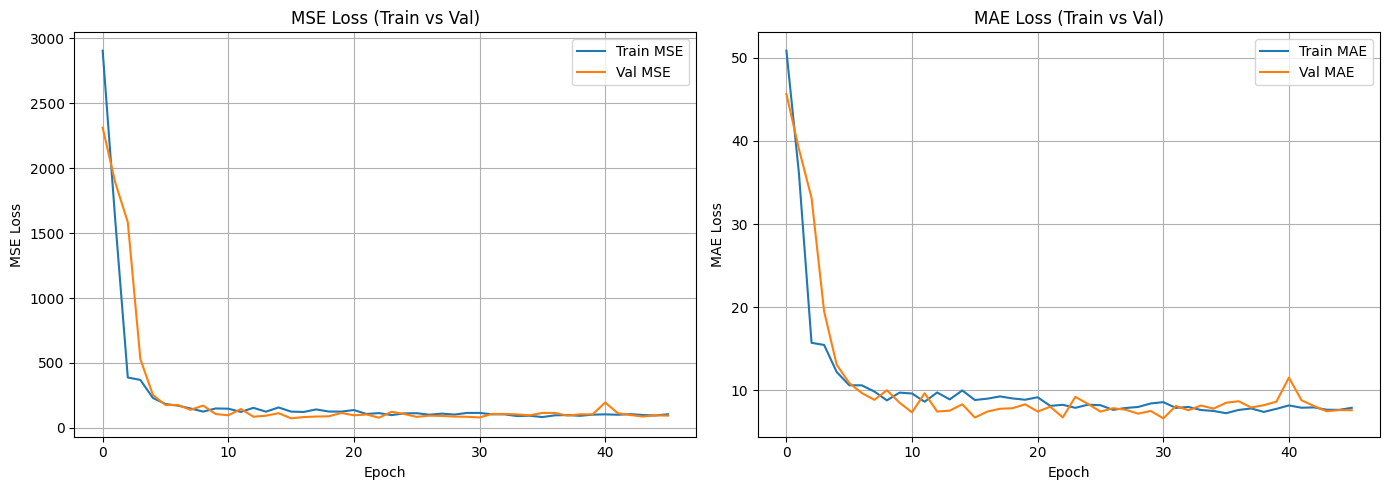

In [16]:
# --- Plotting losses ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_mse, label='Train MSE')
plt.plot(val_losses_mse, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss (Train vs Val)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses_mae, label='Train MAE')
plt.plot(val_losses_mae, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE Loss (Train vs Val)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
within_years = 5  # or any threshold you like

model.eval()
diff = []
correct = 0
all_true_ages = []
all_pred_ages = []

with torch.no_grad():
    for img_batch, feat_batch, y_batch in test_loader:
        img_batch = img_batch.to(device)
        feat_batch = feat_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        y_pred = model(img_batch, feat_batch)
        loss_mse = criterion_mse(y_pred, y_batch)

        true_ages = y_batch     # shape: (batch,)

        # Move to CPU for numpy ops, detach from computation graph
        pred_ages = y_pred.cpu().numpy()
        true_ages = true_ages.cpu().numpy()

        all_true_ages.extend(true_ages)
        all_pred_ages.extend(pred_ages)

        for pred_age, true_age in zip(pred_ages, true_ages):
            difference = abs(pred_age - true_age)
            diff.append(difference)
            if difference <= within_years:
                correct += 1

Number within 5 years: 16/40 (40.00%)
The mean absolute difference: 8.7206


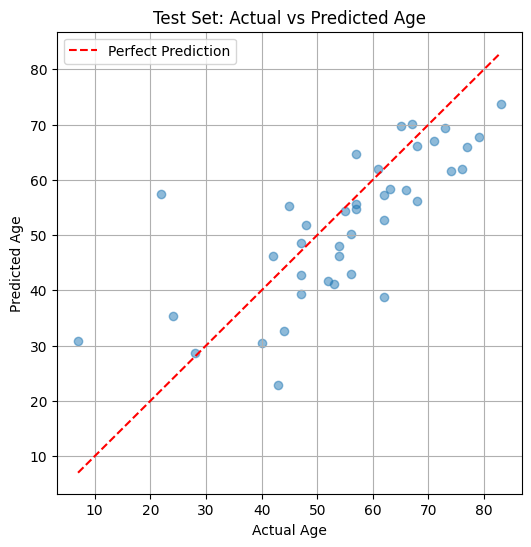

In [22]:
# Final reporting
mean_diff = float(np.mean(diff))
accuracy = correct / len(diff) * 100

print(f'Number within {within_years} years: {correct}/{len(diff)} ({accuracy:.2f}%)')
print(f'The mean absolute difference: {mean_diff:.4f}')

# Optional: Scatter plot of prediction vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(all_true_ages, all_pred_ages, alpha=0.5)
plt.plot([min(all_true_ages), max(all_true_ages)], [min(all_true_ages), max(all_true_ages)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Test Set: Actual vs Predicted Age')
plt.legend()
plt.grid(True)
plt.show()